<a href="https://colab.research.google.com/github/MRPatrick8/NLP/blob/main/assignments/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First Model Assignment
The aim of this assignment is to make sure you understand the foundations of model training. We have covered traditional ML and also simple NN. You task is 


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/NLP/Data/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch==1.8.0 torchtext==0.9.0 #compatibility

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 735.5 MB 10 kB/s 
     |████████████████████████████████| 7.1 MB 41.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.8.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.8.0 which is incompatible.


In [ ]:
import pandas as pd
import re
import torch
from torchtext.legacy import data
from torchtext.legacy.data import Dataset, Example
from torchtext.legacy.data import BucketIterator
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
full_dataset = pd.read_csv('50k_imdb_movie_reviews.csv')
full_dataset.head()

,review,sentiment,set
0,I went and saw this movie last night after bei...,1,test
1,Actor turned director Bill Paxton follows up h...,1,test
2,As a recreational golfer with some knowledge o...,1,test
3,"I saw this film in a sneak preview, and it is ...",1,test
4,Bill Paxton has taken the true story of the 19...,1,test


In [ ]:
full_dataset['review'].describe()

count                                                 50000
unique                                                49582
top       Loved today's show!!! It was a variety and not...
freq                                                      5
Name: review, dtype: object

In [ ]:
full_dataset = full_dataset.drop_duplicates(subset=['review'])
train_dataset = full_dataset[(full_dataset['set'] == 'train')][['review','sentiment']]
test_dataset = full_dataset[(full_dataset['set'] == 'test')][['review','sentiment']]

In [ ]:
def preprocessing(texts):
  cleaned_text = []
  for text in texts:
    text = text.lower()
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    html_pattern = re.compile('<.*?>')
    text = emoji_pattern.sub(r'', text)
    text = url_pattern.sub(r'', text)
    text = html_pattern.sub(r'', text)
    text = re.sub(r"[^\w\d'\s]+", ' ', text)
    cleaned_text.append(text)

  return cleaned_text

1. Code for training traditional ML model that gives the highest accuracy

In [ ]:
# get most common words in training dataset
from collections import Counter 
all_words = []
for line in list(full_dataset['review']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
a=Counter(all_words).most_common(10)
a

[('the', 633981),
 ('a', 314408),
 ('and', 311378),
 ('of', 284608),
 ('to', 262599),
 ('is', 203488),
 ('in', 178487),
 ('i', 140393),
 ('this', 137398),
 ('that', 129179)]

In [ ]:
#tokenization
full_dataset['review'] = full_dataset['review'].apply(lambda x: x.split())
full_dataset.head()

,review,sentiment,set
0,"[I, went, and, saw, this, movie, last, night, ...",1,test
1,"[Actor, turned, director, Bill, Paxton, follow...",1,test
2,"[As, a, recreational, golfer, with, some, know...",1,test
3,"[I, saw, this, film, in, a, sneak, preview,, a...",1,test
4,"[Bill, Paxton, has, taken, the, true, story, o...",1,test


In [ ]:
#stemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

full_dataset['review']= full_dataset['review'].apply(lambda x: [stemmer.stem(i) for i in x])
full_dataset.head()

,review,sentiment,set
0,"[i, went, and, saw, this, movi, last, night, a...",1,test
1,"[actor, turn, director, bill, paxton, follow, ...",1,test
2,"[as, a, recreat, golfer, with, some, knowledg,...",1,test
3,"[i, saw, this, film, in, a, sneak, preview,, a...",1,test
4,"[bill, paxton, has, taken, the, true, stori, o...",1,test


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

#stopwords = set(stopwords.words('english'))
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['u','go','got','via','or','ur','us','in','i','let','the','to','is','amp','make','one','day','days','get']
stopwords.extend(newStopWords)

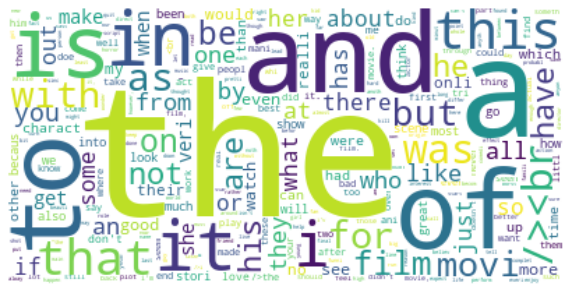

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# split sentences to get individual words
words = []
for line in full_dataset['review']: 
    words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
   ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
def string (text):
    to_return=""
    for i in list(text):
        to_return += str(i) + " "
    to_return = to_return[:-1]
    
    return to_return
    
       
full_dataset['review'] = full_dataset['review'].apply(string)
full_dataset.head()  

,review,sentiment,set
0,i went and saw this movi last night after be c...,1,test
1,actor turn director bill paxton follow up his ...,1,test
2,as a recreat golfer with some knowledg of the ...,1,test
3,"i saw this film in a sneak preview, and it is ...",1,test
4,bill paxton has taken the true stori of the 19...,1,test


In [ ]:
del full_dataset['set']

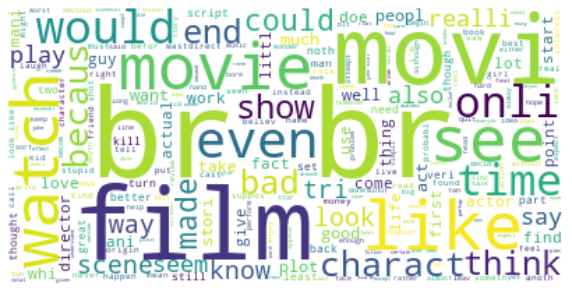

In [ ]:
positive = [r for r in full_dataset['review'][full_dataset['sentiment']==0]]
pos = ''.join(positive)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
   ).generate(pos)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

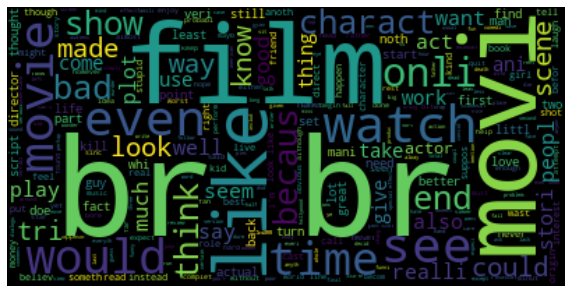

In [ ]:
negative = [r for r in full_dataset['review'][full_dataset['sentiment']==0]]
neg = ''.join(negative)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
    background_color='black',
    max_words=2000,
    stopwords=stopwords
   ).generate(neg)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Split data into training and testing sets 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(full_dataset['review'],full_dataset['sentiment'], test_size = 0.2, random_state = 42)

print("training set :",x_train.shape,y_train.shape)
print("testing set :",x_test.shape,y_test.shape)

training set : (39665,) (39665,)
testing set : (9917,) (9917,)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)
x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)
x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

print(x_test_counts.shape)
print(x_test_tfidf.shape)
print(x_train_counts.shape)
print(x_train_tfidf.shape)

(9917, 87961)
(9917, 87961)
(39665, 87961)
(39665, 87961)


#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200)
model.fit(x_train_tfidf,y_train)
predictions = model.predict(x_test_tfidf)

In [ ]:
#Accuracy_score
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)*100

85.68115357466975

In [ ]:
from sklearn.metrics import confusion_matrix,f1_score
confusion_matrix(y_test,predictions)

array([[4236,  667],
       [ 753, 4261]])

In [ ]:
predictions

array([1, 0, 0, ..., 0, 0, 1])

# Logistc Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(random_state=400 )
logmodel.fit(x_train_tfidf,y_train)
Log_predictions = logmodel.predict(x_test_tfidf)

In [ ]:
#Accuracy_score
from sklearn.metrics import accuracy_score
accuracy_score(y_test,Log_predictions)*100

89.32136734899667

In [ ]:
from sklearn.metrics import confusion_matrix,f1_score
confusion_matrix(y_test,Log_predictions)

array([[4333,  570],
       [ 489, 4525]])

# Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

alg= GradientBoostingRegressor(n_estimators= 550, learning_rate= 0.1, max_depth= 3)
alg.fit(x_train_tfidf,y_train)
alg_predictions = logmodel.predict(x_test_tfidf)

In [ ]:
from sklearn.metrics import confusion_matrix,f1_score
confusion_matrix(y_test,alg_predictions)

array([[4333,  570],
       [ 489, 4525]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,alg_predictions)*100

89.32136734899667

# 2. Code for NN model that gives the highest accuracy

In [ ]:
SEED = 20

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True # Check this
max_document_length = 300 #hyperparameter

TEXT = data.Field(lower=True, include_lengths=True,  tokenize='spacy',preprocessing=preprocessing,batch_first=True,  fix_length=max_document_length)
LABEL = data.Field(sequential=False, use_vocab=False)

class DataFrameDataset(Dataset):
    def __init__(self, df: pd.DataFrame, fields: list):
        super(DataFrameDataset, self).__init__(
            [
                Example.fromlist(list(r), fields) 
                for i, r in df.iterrows()
            ], 
            fields
        )

/usr/local/lib/python3.7/dist-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [ ]:
torch_valid_dataset, torch_test_dataset = DataFrameDataset(
    df=test_dataset, 
    fields=(
        ('review', TEXT),
        ('sentiment', LABEL)
    )
).split() 

torch_train_dataset = DataFrameDataset(
    df=train_dataset, 
    fields=(
        ('review', TEXT),
        ('sentiment', LABEL)
    )
)

In [ ]:
max_size = 30000 #hyperparameter
TEXT.build_vocab(torch_train_dataset, max_size=max_size,vectors='fasttext.simple.300d')
vocab_size = len(TEXT.vocab)

BATCH_SIZE = 50 #hyperparameter
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (torch_train_dataset, torch_valid_dataset, torch_test_dataset), 
    batch_size = BATCH_SIZE ,
    sort_key=lambda x: len(x.review),
    sort_within_batch=True)

class MLP(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size2, hidden_size3, hidden_size4, output_dim, dropout, max_document_length):
        super().__init__()
        # embedding and convolution layers
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(embed_size*max_document_length, hidden_size2)  # dense layer
        self.fc2 = nn.Linear(hidden_size2, hidden_size3)  # dense layer
        self.fc3 = nn.Linear(hidden_size3, hidden_size4)  # dense layer
        self.fc4 = nn.Linear(hidden_size4, output_dim)  # dense layer

    def forward(self, text):
         # text shape = (batch_size, num_sequences)
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
        
        x = embedded.view(embedded.shape[0], -1)  # x = Flatten()(x)
        #embedded = embedded.unsqueeze(1) # fc gets 4 dimension
        
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        preds = self.fc4(x)
        # preds = F.softmax(preds, 1)
        return preds

In [ ]:
lr = 1e-3
batch_size = 30
dropout_keep_prob = 0.3
embedding_size = 300
max_document_length = 300 # each sentence has until 100 words
vocab_size = len(TEXT.vocab)
dev_size = 0.8 # split percentage to train\validation data
max_size = 30000 # maximum vocabulary size
seed = 35
num_classes = 2

num_epochs = 15
hidden_size = 256
hidden_size1 = 300
hidden_size2 = 128
hidden_size3 = 64

to_train = True

model = MLP(vocab_size, embedding_size, hidden_size1, hidden_size2, hidden_size3,  num_classes, dropout_keep_prob, max_document_length)

In [ ]:
def accuracy(probs, target):
  winners = probs.argmax(dim=1)
  corrects = (winners == target)
  accuracy = corrects.sum().float() / float(target.size(0))
  return accuracy

In [ ]:
best_valid_loss = float('inf')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_func = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
  train_epoch_loss = 0
  train_epoch_acc = 0
  for batch in train_iterator:
      optimizer.zero_grad()
      # retrieve text and no. of words
      text, text_lengths = batch.review

      #feedforward
      # model.to(device)
      predictions = model(text).squeeze(1)
      
      
      loss = loss_func(predictions, batch.sentiment)

      acc = accuracy(predictions, batch.sentiment)

      # perform backpropagation
      loss.backward()

      optimizer.step()

      train_epoch_loss += loss.item()
      train_epoch_acc += acc.item()

  

  valid_epoch_loss = 0
  valid_epoch_acc = 0

  model.eval()

  with torch.no_grad():
      for batch in valid_iterator:
          text, text_lengths = batch.review

          predictions = model(text).squeeze(1)

          loss = loss_func(predictions, batch.sentiment)

          acc = accuracy(predictions, batch.sentiment)

          valid_epoch_loss += loss.item()
          valid_epoch_acc += acc.item()

   

  if valid_epoch_loss < best_valid_loss:
            best_valid_loss = valid_epoch_loss
            torch.save(model.state_dict(), 'saved_weights'+'_linear.pt')

  print(f'\tTrain Loss: {train_epoch_loss / len(train_iterator):.3f} | Train Acc: {train_epoch_acc  / len(train_iterator)* 100:.2f}%')
  print(f'\t Val. Loss: {valid_epoch_loss / len(valid_iterator):.3f} |  Val. Acc: {valid_epoch_acc / len(valid_iterator) * 100:.2f}%')

	Train Loss: 0.712 | Train Acc: 51.04%
	 Val. Loss: 0.693 |  Val. Acc: 50.96%
	Train Loss: 0.664 | Train Acc: 57.65%
	 Val. Loss: 0.965 |  Val. Acc: 54.92%
	Train Loss: 0.505 | Train Acc: 70.89%
	 Val. Loss: 0.734 |  Val. Acc: 61.47%
	Train Loss: 0.384 | Train Acc: 81.15%
	 Val. Loss: 0.841 |  Val. Acc: 73.04%
	Train Loss: 0.199 | Train Acc: 91.53%
	 Val. Loss: 0.868 |  Val. Acc: 75.64%
	Train Loss: 0.105 | Train Acc: 95.81%
	 Val. Loss: 0.862 |  Val. Acc: 73.33%
	Train Loss: 0.074 | Train Acc: 97.23%
	 Val. Loss: 0.779 |  Val. Acc: 77.24%
	Train Loss: 0.048 | Train Acc: 98.29%
	 Val. Loss: 0.951 |  Val. Acc: 74.50%
	Train Loss: 0.026 | Train Acc: 99.09%
	 Val. Loss: 1.329 |  Val. Acc: 77.57%
	Train Loss: 0.014 | Train Acc: 99.54%
	 Val. Loss: 1.207 |  Val. Acc: 76.77%
	Train Loss: 0.007 | Train Acc: 99.79%
	 Val. Loss: 1.259 |  Val. Acc: 77.68%
	Train Loss: 0.053 | Train Acc: 98.28%
	 Val. Loss: 1.212 |  Val. Acc: 76.40%
	Train Loss: 0.013 | Train Acc: 99.54%
	 Val. Loss: 1.530 |  Val